In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gekko import GEKKO

In [2]:
# create GEKKO model
m = GEKKO()

In [3]:
# constants
sm = 39.0 #maximal VO2
e0 = 2200 #starting level of energy
e_crit = 0.15 * e0 #critical level of energy, when sigma decreases
g = 9.81 #gravitational constant
distance = 10000 #final horizontal distance to cover [m]
mass = 75 #body mass

expected_finish_time = 1800 #technical - expected solution
maximal_finish_time = 3600 #technical - maximal finish time

In [4]:
# parameters
a = 60 * 50.65
b = 192.86 / 50.65

In [5]:
# time points [s]
nt = 101
tm = np.linspace(0,1,nt)
m.time = tm

In [6]:
# sigma data to create spline
E_data = np.linspace(0, e0, 1001)
sigma_data = sm * E_data/(e0 * e_crit) + 0.75 * sm * (1 - E_data/(e0 * e_crit))
sigma_data[E_data > e_crit] = sm

In [7]:
# slope data to create spline
x_data = np.linspace(0, distance, 500)
slope_data = np.array(250*[1/18 * np.pi] + 250 * [-1/18 * np.pi])

In [8]:
# Variables
v = m.Var(value=0.0, lb=0.0, ub=10.0) #velocity
E = m.Var(value=e0, lb=0.0) #energy
x = m.Var(value=0.0) #horizontal coordinate
t = m.Var(value=0.0, lb=0.0) #time representative
N = m.Var(value=0.0, lb=0.0) # oxidation rate
sigma = m.Var(value=sm, lb=0) #breathing rate
sigma_max = m.Var() #limit of sigma value
slope = m.Var(value=slope_data[0]) #slope

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

In [9]:
# FV - final time
tf = m.FV(value=expected_finish_time,lb=0.1,ub=maximal_finish_time)
tf.STATUS = 1

In [10]:
# MV
u = m.MV(value=0,lb=0,ub=12)
u.STATUS = 1

In [11]:
# energy decrease at the end
m.cspline(E, sigma_max, E_data, sigma_data, True)

# slope
m.cspline(x, slope, x_data, slope_data, True)

In [12]:
# equations
m.Equation(v.dt()==(u - g * m.sin(slope) - v/0.892)*tf)
m.Equation(E.dt()==(sigma - u*v + N * 4 * 4184 * 1/mass)*tf)
m.Equation(x.dt()==(v*m.cos(slope))*tf)
m.Equation(t.dt()==1)
m.Equation(N.dt()==((1/a * m.exp(-(t * tf + a*b)/a))*tf))
m.Equation(sigma<=sigma_max)
m.Equation((distance-x)*final<=0)

In [13]:
# objective
m.Minimize(tf)

In [14]:
m.options.IMODE = 6
m.options.MAX_ITER=1000
m.solve()

print('Final Time: ' + str(tf.value[0]))

apm 90.156.80.122_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            0
   Variables    :           13
   Intermediates:            0
   Connections  :            4
   Equations    :            8
   Residuals    :            8
 
 Number of state variables:           2001
 Number of total equations: -         1800
 Number of slack variables: -          200
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipop

  62  3.1207099e+05 5.52e+04 6.77e+11  -0.4 1.03e+00  11.6 1.29e-02 1.29e-02s 16
  63  3.1234911e+05 5.51e+04 6.74e+11  -0.4 1.82e+00  11.1 6.34e-03 6.34e-03s 16
  64  3.1245083e+05 5.52e+04 6.74e+11  -0.4 4.27e+00  10.6 4.71e-04 4.71e-04s 16
  65  3.1249072e+05 5.52e+04 6.74e+11  -0.4 1.88e+00  11.0 7.87e-04 7.87e-04s 16
  66  3.1297225e+05 5.54e+04 6.73e+11  -0.4 5.34e+00  10.6 1.78e-03 1.78e-03s 16
  67  3.1315634e+05 5.54e+04 6.71e+11  -0.4 1.96e+00  11.0 3.13e-03 3.13e-03s 16
  68  3.1917270e+05 5.82e+04 6.60e+11  -0.4 6.77e+00  10.5 1.75e-02 1.75e-02s 16
  69  3.1950723e+05 5.83e+04 6.58e+11  -0.4 1.97e+00  10.9 4.93e-03 4.93e-03s 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.2634490e+05 6.14e+04 6.49e+11  -0.4 8.74e+00  10.5 1.47e-02 1.47e-02s 16
  71  3.2770537e+05 6.15e+04 6.39e+11  -0.4 1.97e+00  10.9 1.75e-02 1.75e-02s 16
  72  3.4436161e+05 6.92e+04 6.24e+11  -0.4 1.17e+01  10.4 2.50e-02 2.50e-02s 16
  73r 3.4436161e+05 6.92e+04

 153  2.7604241e+05 2.84e-07 9.20e-02 -11.0 1.56e-03   1.8 1.00e+00 1.00e+00f  1
 154  2.7604041e+05 2.56e-06 9.20e-02 -11.0 4.69e-03   1.3 1.00e+00 1.00e+00f  1
 155  2.7603439e+05 2.30e-05 9.20e-02 -10.7 1.41e-02   0.8 1.00e+00 1.00e+00f  1
 156  2.7601633e+05 2.07e-04 9.20e-02 -10.5 4.22e-02   0.3 1.00e+00 1.00e+00f  1
 157  2.7596220e+05 1.86e-03 9.20e-02 -10.2 1.27e-01  -0.1 1.00e+00 1.00e+00f  1
 158  2.7580009e+05 1.67e-02 9.19e-02 -10.8 3.79e-01  -0.6 1.00e+00 1.00e+00f  1
 159  2.7563873e+05 2.77e-02 1.06e-01  -8.8 1.13e+00  -1.1 1.00e+00 3.33e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  2.7546803e+05 4.30e-02 3.20e+00  -7.4 3.37e+00  -1.6 1.00e+00 1.19e-01f  1
 161  2.7546627e+05 4.30e-02 2.07e+01  -6.7 9.87e+00  -2.0 1.00e+00 4.20e-04h  1
 162  2.6394913e+05 1.44e+02 4.07e+00  -6.4 2.70e+01  -2.5 1.00e+00 1.00e+00f  1
 163  2.6059584e+05 3.97e+01 1.43e+02  -6.5 9.79e+00  -2.1 1.00e+00 1.00e+00h  1
 164  2.6050933e+05 9.67e+00

 246  2.2159500e+05 2.10e-07 5.74e-02 -11.0 1.29e-03   1.6 1.00e+00 1.00e+00h  1
 247  2.2159395e+05 1.89e-06 5.74e-02 -11.0 3.86e-03   1.2 1.00e+00 1.00e+00h  1
 248  2.2159081e+05 1.69e-05 5.74e-02  -9.8 1.16e-02   0.7 1.00e+00 9.97e-01h  1
 249  2.2158136e+05 1.53e-04 5.73e-02 -10.9 3.47e-02   0.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  2.2155303e+05 1.37e-03 5.73e-02 -11.0 1.04e-01  -0.3 1.00e+00 1.00e+00f  1
 251  2.2152918e+05 1.95e-03 7.12e-02  -9.0 3.12e-01  -0.7 1.00e+00 2.81e-01h  1
 252  2.2152888e+05 1.94e-03 9.95e+00  -7.0 9.34e-01  -1.2 1.00e+00 1.20e-03h  1
 253  2.2081425e+05 9.24e-01 1.93e+00  -8.0 2.78e+00  -1.7 1.00e+00 9.45e-01f  1
 254  2.2080716e+05 9.21e-01 9.64e+01  -6.0 8.17e+00  -2.2 1.00e+00 3.22e-03h  1
 255  2.1928112e+05 4.95e+00 2.25e+02  -5.5 2.21e+01  -2.6 1.00e+00 2.55e-01f  1
 256  2.1426202e+05 8.60e+01 3.99e+03  -4.2 5.81e+01  -3.1 1.00e+00 3.24e-01f  1
 257  2.1362006e+05 7.98e+00

 344  1.9771445e+05 5.52e+01 3.20e+01  -6.8 2.98e+03  -7.2 1.98e-01 2.73e-03h  1
 345  1.9724850e+05 7.02e+01 1.05e+03  -4.9 9.32e+03  -7.7 9.61e-01 1.32e-02f  1
 346  1.9705459e+05 6.39e+01 1.04e+04  -3.9 9.03e+02  -6.3 9.04e-01 7.69e-02h  1
 347  1.9633599e+05 4.51e+02 3.60e+03  -4.9 3.76e+02  -5.9 6.52e-01 6.97e-01h  1
 348  1.9623078e+05 7.55e+01 4.53e-01  -4.5 9.90e+01  -4.6 1.00e+00 1.00e+00h  1
 349  1.9607358e+05 9.56e+00 1.18e-01  -4.3 1.82e+01  -5.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  1.9598170e+05 4.44e+00 2.04e-02  -4.4 8.91e+00  -4.6 1.00e+00 1.00e+00h  1
 351  1.9571108e+05 5.04e+00 2.99e-03  -4.9 2.63e+01  -5.1 1.00e+00 1.00e+00h  1
 352  1.9483893e+05 2.44e+01 1.03e+00  -5.6 8.31e+01  -5.6 9.99e-01 1.00e+00h  1
 353  1.9483916e+05 2.30e+01 3.79e+01  -5.7 4.95e+01  -3.3 1.00e+00 6.25e-02h  5
 354  1.9483225e+05 3.51e+01 3.64e-01  -6.6 4.65e+01  -3.8 1.00e+00 1.00e+00h  1
 355  1.9478867e+05 6.81e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  1.8122228e+05 1.05e+01 1.12e+03  -3.5 1.21e+01  -0.6 3.90e-02 1.85e-01h  2
 441  1.8122653e+05 1.01e+01 1.47e+03  -3.5 1.05e+01  -1.1 3.83e-01 3.91e-02h  4
 442  1.8123192e+05 9.91e+00 1.43e+03  -3.5 1.01e+01   0.2 1.93e-02 2.01e-02h  1
 443  1.8124405e+05 9.61e+00 2.28e+03  -3.5 9.91e+00  -0.2 2.27e-01 2.98e-02h  1
 444  1.8129854e+05 8.17e+00 1.72e+03  -3.5 9.61e+00  -0.7 8.83e-02 1.50e-01h  1
 445  1.8129858e+05 8.17e+00 3.47e+03  -3.5 8.17e+00   0.6 5.55e-01 1.09e-04h  1
 446  1.8132260e+05 7.70e+00 3.43e+03  -3.5 8.17e+00   1.0 1.70e-01 5.77e-02h  1
 447  1.8132319e+05 7.69e+00 4.46e+03  -3.5 7.70e+00   0.6 8.90e-01 1.25e-03h  1
 448  1.8135419e+05 7.20e+00 4.19e+03  -3.5 7.69e+00   0.1 1.88e-01 6.37e-02h  1
 449  1.8135534e+05 7.18e+00 4.28e+03  -3.5 7.20e+00   1.4 1.00e+00 2.07e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  1.8137864e+05 6.89e+00

 534r 1.9431259e+05 3.51e+03 1.00e+03   1.3 0.00e+00   9.8 0.00e+00 3.08e-07R  4
 535r 1.9522962e+05 3.26e+03 1.04e+03  -1.5 8.05e+04    -  1.07e-02 1.66e-03f  1
 536  1.9522901e+05 3.26e+03 4.71e+04  -0.8 8.30e+02    -  6.05e-01 8.30e-04f  1
 537  1.9426846e+05 4.45e+02 1.52e+04  -0.8 1.51e+03    -  7.41e-01 9.61e-01h  1
 538  1.9319134e+05 5.63e+03 6.27e+05  -0.8 3.36e+03    -  6.41e-01 1.00e+00h  1
 539  1.9319124e+05 5.63e+03 8.18e+06  -0.8 9.74e+00   9.3 7.45e-04 4.26e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540r 1.9319124e+05 5.63e+03 1.00e+03   1.0 0.00e+00   8.8 0.00e+00 3.30e-07R  5
 541r 1.9306923e+05 2.75e+03 9.99e+02   0.0 2.80e+03    -  7.69e-03 3.44e-03f  1
 542  1.9306915e+05 2.74e+03 4.22e+04  -0.8 3.75e+01    -  9.90e-01 1.39e-03h  1
 543  1.9259949e+05 2.42e+03 3.73e+04  -0.8 1.09e+03    -  1.25e-01 1.21e-01h  4
 544  1.9227471e+05 2.13e+03 7.42e+04  -0.8 8.47e+02    -  9.81e-01 1.24e-01h  4
 545  1.9189325e+05 1.87e+03

Scaling factors are invalid - setting them all to 1.
 617r 1.8305315e+05 6.51e+06 1.00e+03   3.2 0.00e+00  14.4 0.00e+00 4.93e-07R  5
 618r 1.6888610e+05 9.66e+05 9.09e+04   0.9 1.29e+05    -  6.32e-02 1.15e-02f  1
 619  1.7006716e+05 9.56e+05 3.00e+02   1.9 4.69e+05    -  1.17e-02 1.03e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620  1.7199188e+05 9.01e+05 3.93e+02   1.9 5.07e+04    -  4.63e-01 5.62e-02h  1
 621  1.7233987e+05 8.80e+05 9.92e+02   1.9 1.69e+05    -  6.14e-03 2.26e-02f  1
 622  1.7179869e+05 8.74e+05 7.01e+11   1.9 8.69e-03  13.9 9.90e-01 9.90e-01s 22
 623r 1.7179869e+05 8.74e+05 9.99e+02   2.6 0.00e+00  13.4 0.00e+00 0.00e+00R  1
 624r 1.6848866e+05 6.51e+05 9.90e+02   1.9 2.19e+05    -  2.51e-02 1.39e-03f  1
 625  1.6937746e+05 6.47e+05 9.40e+01   1.9 2.49e+05    -  5.53e-02 5.30e-03f  1
 626  1.7017399e+05 5.95e+05 2.17e+15   1.9 1.30e+02  13.0 9.90e-01 8.05e-02h  1
 627  1.7073034e+05 5.97e+05 2.45e+15   1.9 3.09e-03  17

In [15]:
tm = tm * tf.value[0]

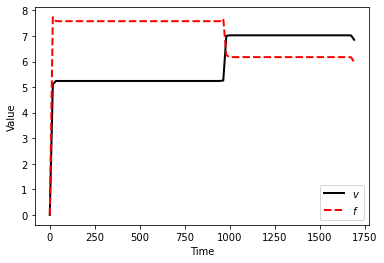

In [16]:
plt.figure(1)
plt.plot(tm,v.value,'k-',lw=2,label=r'$v$')
plt.plot(tm,u.value,'r--',lw=2,label=r'$f$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

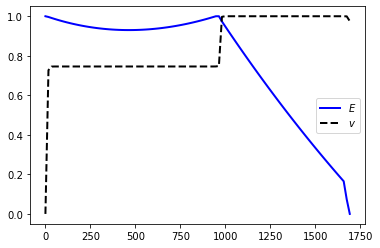

In [17]:
plt.figure(2)
plt.plot(tm,np.array(E.value)/max(E.value),'b-',lw=2,label=r'$E$')
plt.plot(tm,np.array(v.value)/max(v.value),'k--',lw=2,label=r'$v$')
plt.legend()
plt.show()

In [18]:
np.array(N.value) * 4 * 4164 * 1/mass

array([0.        , 0.02728034, 0.05440929, 0.08138771, 0.10821643,
       0.13489628, 0.16142808, 0.18781265, 0.21405082, 0.2401434 ,
       0.26609119, 0.29189499, 0.31755561, 0.34307384, 0.36845047,
       0.39368629, 0.41878207, 0.4437386 , 0.46855664, 0.49323697,
       0.51778035, 0.54218754, 0.56645929, 0.59059637, 0.6145995 ,
       0.63846944, 0.66220693, 0.6858127 , 0.70928749, 0.73263201,
       0.75584699, 0.77893316, 0.80189122, 0.82472189, 0.84742587,
       0.87000386, 0.89245658, 0.9147847 , 0.93698893, 0.95906994,
       0.98102843, 1.00286507, 1.02458054, 1.04617551, 1.06765065,
       1.08900663, 1.1102441 , 1.13136373, 1.15236616, 1.17325206,
       1.19402206, 1.2146768 , 1.23521693, 1.25564309, 1.2759559 ,
       1.296156  , 1.31624401, 1.33622055, 1.35608624, 1.3758417 ,
       1.39548753, 1.41502436, 1.43445277, 1.45377337, 1.47298676,
       1.49209354, 1.5110943 , 1.52998962, 1.5487801 , 1.5674663 ,
       1.58604882, 1.60452822, 1.62290508, 1.64117997, 1.65935

In [19]:
# available VO2 depending on event time and altitude
# reference: Minetti

VO2_max = 55
event_time = 4 * 60 * 60
altitude = 1200

def fract_duration(event_time):
    return (940 - event_time/60) / 1000

def fract_altitude(alt):
    return 1 - 11.7 * 10**(-9) * alt**2 - 4.01 * 10**(-6) * alt

fract_duration = fract_duration(event_time)
fract_altitude = fract_altitude(altitude)

print(VO2_max * fract_duration * fract_altitude)

37.66609
